# Validation with the American Gut data

The purpose of this notebook is to evaluate the effects of different deblurring depths on the biological patterns in data from the [American Gut Project](www.americangut.org). We expect the alpha diversity of a bacterial community to significantly increase with age, as previously seen [[1](#1),[2](#2)].

The metadata was downloaded from the American Gut FTP for [July-29-2016](ftp.microbio.me/AmericanGut/ag-July-29-2016/01-raw/metadata.txt), and has been placed in the data directory.

In [17]:
import pandas as pd
map_ = pd.read_csv('../data/ag.qiita-10317.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

We'll work with fecal samples from a subset of adults 20-69 with BMIs between 18.5 and 30, no history of diabetes or inflammatory bowel disease who have  not use antibiotics in the past year.

In [5]:
map_ = map_.loc[map_['SUBSET_HEALTHY'].apply(lambda x: x in {'True', 'true'})]
map_ = map_.loc[map_['BODY_HABITAT'] == 'UBERON:feces']

The full biom table was generated using deblurring (see Amir et al, 2016, companion paper). Shannon diversity was calculated in QIIME 1.9.1 [[3](#3)], where it is assumed the files are in a folder below the notebook, and sequence depth (i.e. `bloom10`) changes to appropriately reflect the number of filtered sequences.

We first generated the filtered tables, using the `filter_seqs_from_biom.py` function in this repository. We ran this inside the `bloom` directory.

```bash
mkdir biom
for i in `seq 0 21`;
do
    python filter_seqs_from_biom.py -i ../data/ag.qiita-10317.biom -f ../data/newbloom.all.fna 
    -o ../data/biom/ag.qiita-10317.bloom$i.biom -n $i
done
```

We then use QIIME to perform muliple rarefaction and calculate alpha diversity.

```bash
for i in `seq 0 21`;
do
    multiple_rarefactions_even_depth.py -i ../data/biom/ag.qiita-10317.bloom$i.biom -d 2000 
    -o ../data/rarefaction/$i/ -n 10

    alpha_diversity.py -i ../data/rarefaction/$i/ -o ../data/alpha/$i/ -m shannon
    
    collate_alpha.py -i ../data/alpha/$i/ -o ../data/alphacollated/$i/
done    
```

For convenience, the collated alpha diversity files have been placed in the `data` directory.


We'll import those files, and calculate the mean diversity for each of the rarefaction instances.

In [7]:
import numpy as np

numfilter=22

for i in range(numfilter):
    diversity = pd.read_csv('../data/alphacollated/%i/shannon.txt' % i, sep='\t', index_col=0)
    map_['shannon_%i' % i] = diversity.mean()

Let's filter out any samples which do not appear after all filtering.

In [8]:
map_ = map_.loc[map_['shannon_%i' % (numfilter-1)].dropna().index]

Now, we can perform the comparisons with age. We'll use a [kruskal wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) test, and calculate a test statistic and p-value.

In [9]:
from scipy.stats import kruskal
ages = ['20s', '30s', '40s', '50s', '60s']

kruskal_results = [kruskal(*[map_.loc[map_['AGE_CAT'] == age, 'shannon_%i' % filter_].dropna()
                            for age in ages]) for filter_ in range(numfilter)]
statitics, p_values = zip(*kruskal_results)

Let's plot our test statitics as a function of filtering depth.

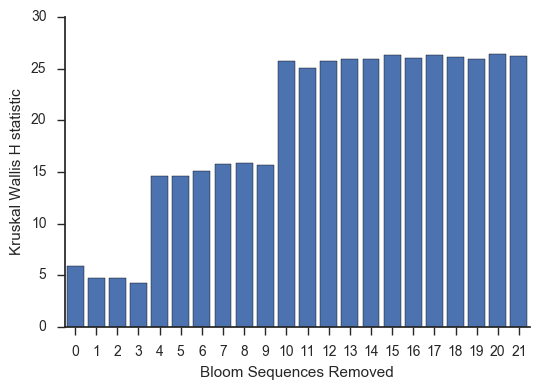

In [10]:
# Sets up pretty plots
from matplotlib import use
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style('ticks')
% matplotlib inline

# Plots the data
ax = plt.axes()
ax.bar(left=np.arange(0, numfilter) + 0.1,
       height=statitics,
       width=0.8,
       )
# Formats and labels the axes
ax.set_xlim([0, numfilter])
ax.set_xticks(np.arange(0.5, numfilter))
ax.set_xticklabels(map(int, range(numfilter)))
ax.set_xlabel('Bloom Sequences Removed')
ax.set_ylabel('Kruskal Wallis H statistic')
sn.despine()

# Saves the figure
ax.figure.savefig('../results/bloom_statistic.pdf')

Now, let's plot the negative log of the p-values.

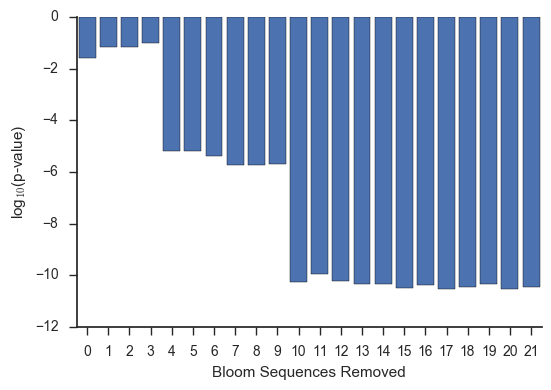

In [11]:
# Plots the data
ax = plt.axes()
ax.bar(left=np.arange(0, numfilter) + 0.1,
       height=np.log(np.array(p_values)),
       width=0.8,
       )
# Formats and labels the axes
ax.set_xlim([0, numfilter])
ax.set_xticks(np.arange(0.5, numfilter))
ax.set_xticklabels(map(int, range(numfilter)))
ax.set_xlabel('Bloom Sequences Removed')
ax.set_ylabel('log$_{10}$(p-value)')
sn.despine()

# Saves the figure
ax.figure.savefig('../results/bloom_p-value.pdf')

Therefore, we have demonstrated the ability to see a significant difference with reguard to age in the American Gut population is dependent on the bloom filter depth.

# References

<ol><li>
<a id="1"></a>Yatsunenko, T.; Rey, F.E.; Manary, M.J.; Trehan I.; Dominguez-Bello, M.G.; Contreras, M.; Magris, M.' Hidalgo, G.; Baldassano, R.N.; Anokhin, A.P.; Heath, A.C.; Warner, B.; Reeder, J.; Kuczynski, J.; Caporaso, J.G.; Lozupone, C.A.; Lauber, C.; Clemente, J.C.; Knights, D.; Knight, R.; Gordon, J.I. (2012). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/22699611">Human gut microbiome viewed across age and geography</a>". <em>Nature</em>. <strong>486</strong>: 222-227.<br>
</li><li>
<a id="2"></a>Koenig, J.E.; Spor, A.; Scalfone, N.; Fricker, A.D.; Stombaugh, J.; Knight, R.; Angenent, L.T.; Ley, R.E. (2011). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/20668239">Succession of microbial consortia in the developing infant gut microbiome</a>". <em>PNAS</em>. <strong>108 Suppl 1</strong>: 4578-4585.<br>
</li><li>
<a id="3"></a>Caporaso, J.G.; Kuczynski, J.; Stombaugh, J.; Bittinger, K.; Bushman, F.D; Costello, E.K; Fierer, N.; Pena, A.G.; Goodrich, J.K.; Gordon, J.I.; Huttley, G.A.; Kelley, S.T.; Knights, D.; Koenig, J.E.; Ley, R.; Lozupone, C.A.; McDonald, D., Muegge, B.D.; Pirrung, M.; Reeder, J.; Sevinsky, J.R.; Turnbaugh, P.J.; Walters, W.A.; Widmann, J.; Yatsunenko, T.; Zaneveld, J.; Knight, R. (2010). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/20383131">QIIME allows analysis of high-throughput community sequencing data</a>". <em>Nat Methods</em>. <strong>7</strong>:335 - 336.
</li></ol>